In [4]:
!pip install torchviz

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary
from torchviz import make_dot


In [6]:
from tqdm import tqdm  # for progres bar

In [7]:
class Fire(nn.Module):
    def __init__(self, in_channels, squeeze_channels, expand1x1_channels, expand3x3_channels):
        super(Fire, self).__init__()
        self.squeeze = nn.Conv2d(in_channels, squeeze_channels, kernel_size=1)
        self.relu_squeeze = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_channels, expand1x1_channels, kernel_size=1)
        self.relu_expand1x1 = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_channels, expand3x3_channels, kernel_size=3, padding=1)
        self.relu_expand3x3 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze(x)
        x = self.relu_squeeze(x)
        out1x1 = self.expand1x1(x)
        out1x1 = self.relu_expand1x1(out1x1)
        out3x3 = self.expand3x3(x)
        out3x3 = self.relu_expand3x3(out3x3)
        return torch.cat([out1x1, out3x3], 1)

class SqueezeNet_Residual(nn.Module):
    def __init__(self, num_classes=1000):
        super(SqueezeNet_Residual, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2)
        self.relu_conv1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fire2 = Fire(96, 16, 64, 64)
        self.fire3 = Fire(128, 16, 64, 64)
        self.fire4 = Fire(128, 32, 128, 128)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fire5 = Fire(256, 32, 128, 128)
        self.fire6 = Fire(256, 48, 192, 192)
        self.fire7 = Fire(384, 48, 192, 192)
        self.fire8 = Fire(384, 64, 256, 256)
        self.pool8 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fire9 = Fire(512, 64, 256, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.conv10 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.relu_conv10 = nn.ReLU(inplace=True)
        self.pool10 = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu_conv1(x)
        x = self.pool1(x)
        x = self.fire2(x)
        x = self.fire3(x)
        bypass_23 = x  
        x = self.fire4(x)
        x = self.pool4(x)
        bypass_45 = x  
        x = self.fire5(x)
        bypass_67 = x  
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.fire8(x)
        x = self.pool8(x)
        bypass_89 = x  
        x = self.fire9(x)
        x = self.dropout(x)
        x = self.conv10(x)
        x = self.relu_conv10(x)
        x = self.pool10(x)
        return x


In [8]:
model = SqueezeNet_Residual(num_classes=1000)  
print(model)

SqueezeNet_Residual(
  (conv1): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
  (relu_conv1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fire2): Fire(
    (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
    (relu_squeeze): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (relu_expand1x1): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_expand3x3): ReLU(inplace=True)
  )
  (fire3): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (relu_squeeze): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (relu_expand1x1): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_expand3x3): ReLU(inplace=True)
  )
  (fire4): Fire(
    (squeeze): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

sample_input = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    model.eval()  
    output = model(sample_input)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 109, 109]          14,208
              ReLU-2         [-1, 96, 109, 109]               0
         MaxPool2d-3           [-1, 96, 54, 54]               0
            Conv2d-4           [-1, 16, 54, 54]           1,552
              ReLU-5           [-1, 16, 54, 54]               0
            Conv2d-6           [-1, 64, 54, 54]           1,088
              ReLU-7           [-1, 64, 54, 54]               0
            Conv2d-8           [-1, 64, 54, 54]           9,280
              ReLU-9           [-1, 64, 54, 54]               0
             Fire-10          [-1, 128, 54, 54]               0
           Conv2d-11           [-1, 16, 54, 54]           2,064
             ReLU-12           [-1, 16, 54, 54]               0
           Conv2d-13           [-1, 64, 54, 54]           1,088
             ReLU-14           [-1, 64,

In [10]:
dot = make_dot(model(sample_input), params=dict(model.named_parameters()))
dot.format = 'png'
dot.render("SqueezeNet_Residual_Model", format="png", cleanup=True)

'SqueezeNet_Residual_Model.png'

In [11]:
# Training on CIFAR 10

In [12]:
# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SqueezeNet_Residual(num_classes=10).to(device)

[Epoch 1] train=639.622000 val=639.010000 loss=2.302583 time: 45.966183
[Epoch 2] train=639.910000 val=639.040000 loss=2.302583 time: 41.664326
[Epoch 3] train=640.012000 val=639.040000 loss=2.302583 time: 37.903563
[Epoch 4] train=639.904000 val=639.040000 loss=2.302583 time: 41.614129
[Epoch 5] train=639.808000 val=639.040000 loss=2.302583 time: 39.895318
[Epoch 6] train=639.712000 val=639.040000 loss=2.302583 time: 41.971678
[Epoch 7] train=639.904000 val=639.040000 loss=2.302583 time: 38.387306
[Epoch 8] train=640.000000 val=639.040000 loss=2.302583 time: 43.406873
[Epoch 9] train=639.904000 val=639.040000 loss=2.302583 time: 39.462652
[Epoch 10] train=639.808000 val=639.040000 loss=2.302583 time: 38.322443


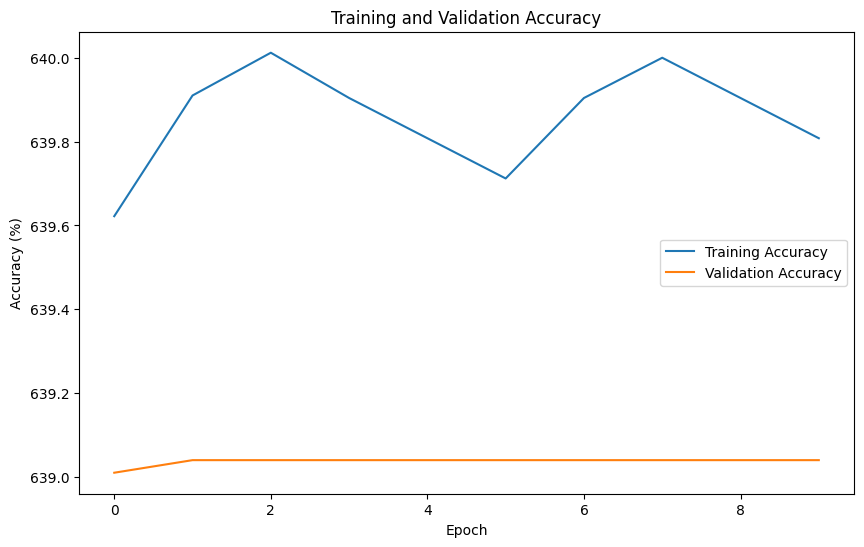

In [18]:
import time
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize training and validation accuracy
train_acc_history = []
val_acc_history = []
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    tic = time.time()  # Start time for the epoch
    
    # Training loop
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        labels = labels.unsqueeze(1).unsqueeze(2)  # Reshape labels to 3D tensor
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()
    train_acc = 100 * correct / total
    train_acc_history.append(train_acc)

    if i % 100 == 99:
        print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
        running_loss = 0.0

    # Validation loop
    correct = 0
    total = 0
    for i, data in enumerate(testloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    val_acc_history.append(val_acc)

    print(f'[Epoch {epoch + 1}] train={train_acc:.6f} val={val_acc:.6f} loss={running_loss / len(trainloader):.6f} time: {time.time() - tic:.6f}')

# Plot the training and validation accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Files already downloaded and verified
Files already downloaded and verified
[Epoch 1] train=336.180000 val=336.770000 loss=2.114847 time: 55.457562
[Epoch 2] train=346.234000 val=355.920000 loss=1.674407 time: 54.471953
[Epoch 3] train=354.424000 val=359.560000 loss=1.466728 time: 51.707525
[Epoch 4] train=360.478000 val=359.280000 loss=1.355710 time: 50.072349
[Epoch 5] train=364.804000 val=365.910000 loss=1.264146 time: 51.598224
[Epoch 6] train=368.192000 val=367.120000 loss=1.191862 time: 52.162302
[Epoch 7] train=368.988000 val=371.290000 loss=1.126616 time: 50.336092
[Epoch 8] train=372.356000 val=374.140000 loss=1.073802 time: 53.770515
[Epoch 9] train=373.184000 val=374.810000 loss=1.023307 time: 54.849544
[Epoch 10] train=374.924000 val=375.330000 loss=0.982932 time: 53.334118
[Epoch 11] train=376.100000 val=373.470000 loss=0.941588 time: 55.622941
[Epoch 12] train=376.780000 val=377.750000 loss=0.912652 time: 53.376709
[Epoch 13] train=377.190000 val=377.880000 loss=0.884934 

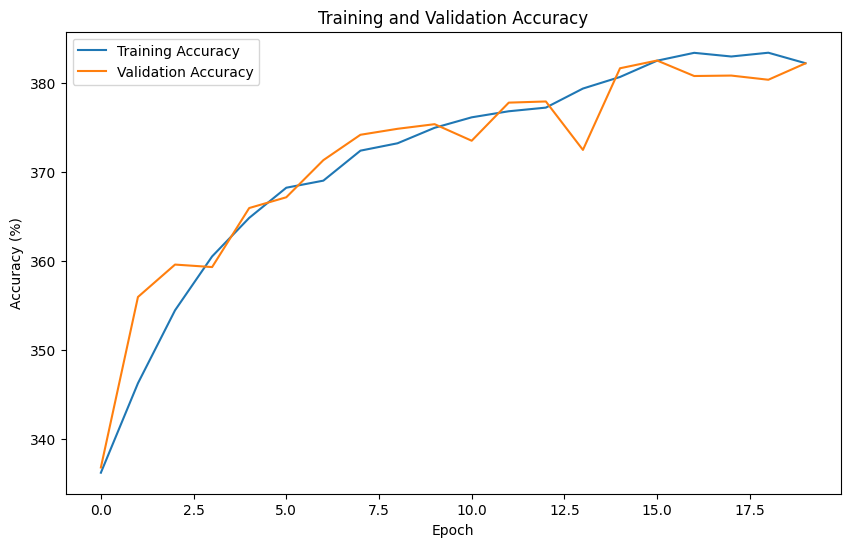

[Epoch 1] train=371.188000 val=375.420000 loss=1.082602 time: 47.854124



KeyboardInterrupt



In [21]:
import time
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn import init

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR10 dataset with the transformations
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_sizes = [32, 64, 128]
for batch_size in batch_sizes:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Initialize the model
    model = SqueezeNet_Residual(num_classes=10).to(device)

    # Try different weight initialization methods
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal_(m.weight, 0, 0.01)
            init.constant_(m.bias, 0)

    # Try different optimizers
    optimizers = [
        optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
        optim.Adam(model.parameters(), lr=0.001),
        optim.RMSprop(model.parameters(), lr=0.001)
    ]
    for optimizer in optimizers:
        criterion = nn.CrossEntropyLoss(ignore_index=-1)
        optimizer = optimizer

        # Training loop
        train_acc_history = []
        val_acc_history = []
        num_epochs = 20

        for epoch in range(num_epochs):
            running_loss = 0.0
            tic = time.time()

            # Training loop
            correct = 0
            total = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                labels = labels.unsqueeze(1).unsqueeze(2)  # Reshape labels to 3D tensor
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels.squeeze()).sum().item()
            train_acc = 100 * correct / total
            train_acc_history.append(train_acc)

            if i % 100 == 99:
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
                running_loss = 0.0

            # Validation loop
            correct = 0
            total = 0
            for i, data in enumerate(testloader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            val_acc = 100 * correct / total
            val_acc_history.append(val_acc)

            print(f'[Epoch {epoch + 1}] train={train_acc:.6f} val={val_acc:.6f} loss={running_loss / len(trainloader):.6f} time: {time.time() - tic:.6f}')

        # Plot the training and validation accuracy
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        plt.plot(train_acc_history, label='Training Accuracy')
        plt.plot(val_acc_history, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.show()

Files already downloaded and verified
Files already downloaded and verified
Batch size: 64, Optimizer: SGD


Epoch 1/20: 100%|██████████| 782/782 [00:35<00:00, 21.92batch/s, accuracy=643, loss=2.21]


[Epoch 1] train=642.844000 val=652.220000 loss=2.209835 time: 43.206861


Epoch 2/20: 100%|██████████| 782/782 [00:38<00:00, 20.36batch/s, accuracy=661, loss=1.79]


[Epoch 2] train=661.142000 val=668.410000 loss=1.787605 time: 45.867066


Epoch 3/20: 100%|██████████| 782/782 [00:38<00:00, 20.46batch/s, accuracy=669, loss=1.56]


[Epoch 3] train=669.408000 val=673.350000 loss=1.557713 time: 46.089910


Epoch 4/20: 100%|██████████| 782/782 [00:38<00:00, 20.55batch/s, accuracy=677, loss=1.45]


[Epoch 4] train=677.042000 val=676.530000 loss=1.447172 time: 46.310157


Epoch 5/20: 100%|██████████| 782/782 [00:38<00:00, 20.16batch/s, accuracy=680, loss=1.35]


[Epoch 5] train=679.584000 val=680.140000 loss=1.345882 time: 47.919465


Epoch 6/20: 100%|██████████| 782/782 [00:38<00:00, 20.48batch/s, accuracy=686, loss=1.25]


[Epoch 6] train=685.972000 val=685.760000 loss=1.253946 time: 46.594099


Epoch 7/20: 100%|██████████| 782/782 [00:41<00:00, 18.81batch/s, accuracy=688, loss=1.19]


[Epoch 7] train=687.682000 val=686.240000 loss=1.189301 time: 49.325356


Epoch 8/20: 100%|██████████| 782/782 [00:46<00:00, 16.89batch/s, accuracy=690, loss=1.14]


[Epoch 8] train=690.412000 val=691.760000 loss=1.136588 time: 55.646968


Epoch 9/20: 100%|██████████| 782/782 [00:46<00:00, 16.91batch/s, accuracy=691, loss=1.09]


[Epoch 9] train=691.342000 val=691.810000 loss=1.090912 time: 55.213010


Epoch 10/20: 100%|██████████| 782/782 [00:40<00:00, 19.08batch/s, accuracy=693, loss=1.04]


[Epoch 10] train=693.104000 val=692.340000 loss=1.038912 time: 49.781443


Epoch 11/20: 100%|██████████| 782/782 [00:44<00:00, 17.65batch/s, accuracy=693, loss=1]   


[Epoch 11] train=693.274000 val=693.790000 loss=1.002728 time: 52.192394


Epoch 12/20: 100%|██████████| 782/782 [00:41<00:00, 18.75batch/s, accuracy=698, loss=0.971]


[Epoch 12] train=697.536000 val=689.850000 loss=0.970505 time: 51.223141


Epoch 13/20: 100%|██████████| 782/782 [00:44<00:00, 17.61batch/s, accuracy=698, loss=0.941]


[Epoch 13] train=697.768000 val=694.960000 loss=0.941401 time: 53.071181


Epoch 14/20: 100%|██████████| 782/782 [00:43<00:00, 17.99batch/s, accuracy=697, loss=0.903]


[Epoch 14] train=697.320000 val=693.750000 loss=0.902930 time: 52.458419


Epoch 15/20: 100%|██████████| 782/782 [00:43<00:00, 17.93batch/s, accuracy=701, loss=0.88] 


[Epoch 15] train=700.762000 val=699.610000 loss=0.879924 time: 53.832304


Epoch 16/20: 100%|██████████| 782/782 [00:42<00:00, 18.33batch/s, accuracy=701, loss=0.85] 


[Epoch 16] train=700.882000 val=698.830000 loss=0.850469 time: 52.420360


Epoch 17/20: 100%|██████████| 782/782 [00:45<00:00, 17.21batch/s, accuracy=701, loss=0.837]


[Epoch 17] train=701.344000 val=700.320000 loss=0.837179 time: 54.578326


Epoch 18/20: 100%|██████████| 782/782 [00:43<00:00, 17.85batch/s, accuracy=700, loss=0.807]


[Epoch 18] train=699.604000 val=699.010000 loss=0.806714 time: 52.747263


Epoch 19/20: 100%|██████████| 782/782 [00:40<00:00, 19.08batch/s, accuracy=702, loss=0.789]


[Epoch 19] train=702.140000 val=700.130000 loss=0.788739 time: 48.596216


Epoch 20/20: 100%|██████████| 782/782 [00:39<00:00, 20.00batch/s, accuracy=702, loss=0.766]


[Epoch 20] train=701.670000 val=701.790000 loss=0.765639 time: 47.263233


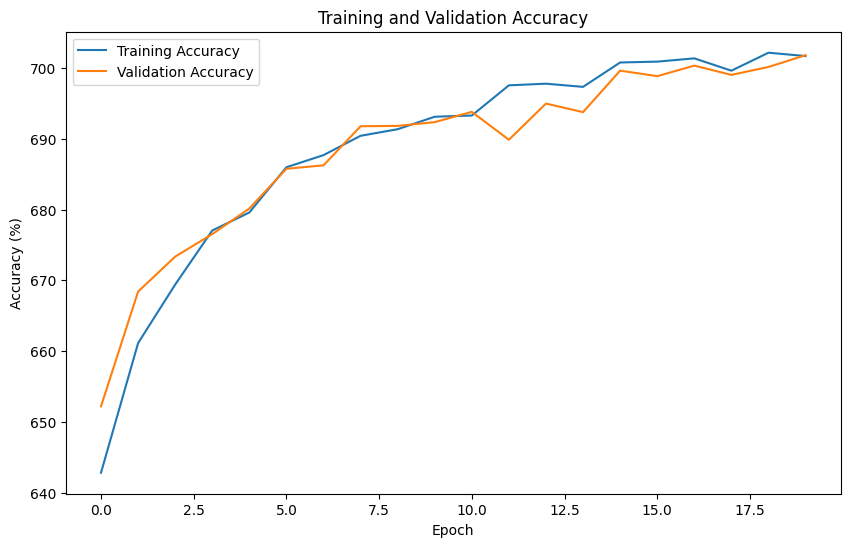

Batch size: 64, Optimizer: Adam


Epoch 1/20: 100%|██████████| 782/782 [00:43<00:00, 18.00batch/s, accuracy=676, loss=1.52]


[Epoch 1] train=675.822000 val=688.970000 loss=1.524206 time: 51.365818


Epoch 2/20: 100%|██████████| 782/782 [00:36<00:00, 21.26batch/s, accuracy=692, loss=1.07]


[Epoch 2] train=692.312000 val=692.360000 loss=1.072570 time: 44.573120


Epoch 3/20: 100%|██████████| 782/782 [00:34<00:00, 22.41batch/s, accuracy=695, loss=0.962]


[Epoch 3] train=694.710000 val=692.340000 loss=0.962087 time: 43.150331


Epoch 4/20: 100%|██████████| 782/782 [00:39<00:00, 19.66batch/s, accuracy=699, loss=0.888]


[Epoch 4] train=698.530000 val=701.800000 loss=0.888474 time: 48.350147


Epoch 5/20: 100%|██████████| 782/782 [00:40<00:00, 19.43batch/s, accuracy=699, loss=0.828]


[Epoch 5] train=698.650000 val=701.070000 loss=0.828472 time: 49.793090


Epoch 6/20: 100%|██████████| 782/782 [00:35<00:00, 22.01batch/s, accuracy=703, loss=0.773]


[Epoch 6] train=703.426000 val=700.560000 loss=0.773327 time: 43.939771


Epoch 7/20: 100%|██████████| 782/782 [00:37<00:00, 20.61batch/s, accuracy=704, loss=0.738]


[Epoch 7] train=703.650000 val=703.330000 loss=0.738089 time: 45.881599


Epoch 8/20: 100%|██████████| 782/782 [00:37<00:00, 20.91batch/s, accuracy=707, loss=0.718]


[Epoch 8] train=707.174000 val=703.200000 loss=0.718490 time: 45.915631


Epoch 9/20: 100%|██████████| 782/782 [00:42<00:00, 18.50batch/s, accuracy=707, loss=0.678]


[Epoch 9] train=706.588000 val=703.570000 loss=0.677818 time: 50.521199


Epoch 10/20: 100%|██████████| 782/782 [00:40<00:00, 19.45batch/s, accuracy=704, loss=0.66] 


[Epoch 10] train=704.380000 val=704.700000 loss=0.660331 time: 48.006356


Epoch 11/20: 100%|██████████| 782/782 [00:38<00:00, 20.56batch/s, accuracy=707, loss=0.647]


[Epoch 11] train=706.568000 val=706.080000 loss=0.646518 time: 46.975616


Epoch 12/20: 100%|██████████| 782/782 [00:36<00:00, 21.37batch/s, accuracy=705, loss=0.628]


[Epoch 12] train=705.068000 val=707.730000 loss=0.627547 time: 44.594678


Epoch 13/20: 100%|██████████| 782/782 [00:38<00:00, 20.45batch/s, accuracy=709, loss=0.604]


[Epoch 13] train=708.782000 val=706.790000 loss=0.603555 time: 47.839216


Epoch 14/20: 100%|██████████| 782/782 [00:43<00:00, 17.85batch/s, accuracy=709, loss=0.597]


[Epoch 14] train=708.962000 val=706.750000 loss=0.597412 time: 52.643612


Epoch 15/20: 100%|██████████| 782/782 [00:43<00:00, 18.05batch/s, accuracy=708, loss=0.576]


[Epoch 15] train=708.024000 val=707.640000 loss=0.575736 time: 52.616503


Epoch 16/20: 100%|██████████| 782/782 [00:41<00:00, 18.93batch/s, accuracy=709, loss=0.566]


[Epoch 16] train=708.622000 val=705.580000 loss=0.566263 time: 50.583161


Epoch 17/20: 100%|██████████| 782/782 [00:43<00:00, 17.87batch/s, accuracy=711, loss=0.553]


[Epoch 17] train=711.014000 val=706.480000 loss=0.552601 time: 53.143326


Epoch 18/20: 100%|██████████| 782/782 [00:42<00:00, 18.42batch/s, accuracy=713, loss=0.557]


[Epoch 18] train=712.848000 val=708.970000 loss=0.557092 time: 51.675823


Epoch 19/20: 100%|██████████| 782/782 [00:37<00:00, 21.11batch/s, accuracy=712, loss=0.534]


[Epoch 19] train=712.002000 val=706.290000 loss=0.533876 time: 45.660927


Epoch 20/20: 100%|██████████| 782/782 [00:43<00:00, 18.18batch/s, accuracy=712, loss=0.531]


[Epoch 20] train=711.638000 val=706.260000 loss=0.530848 time: 52.996000


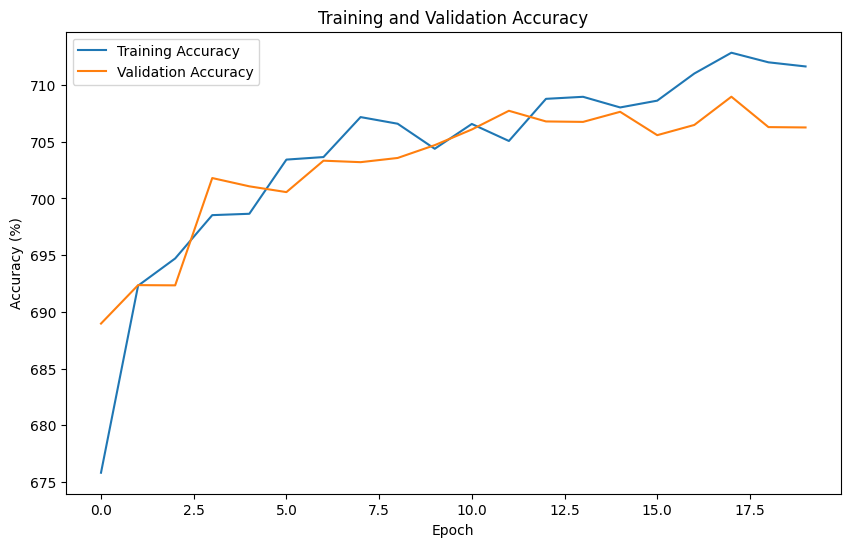

Batch size: 64, Optimizer: RMSprop


Epoch 1/20: 100%|██████████| 782/782 [00:41<00:00, 18.89batch/s, accuracy=697, loss=0.96] 


[Epoch 1] train=696.722000 val=703.800000 loss=0.960175 time: 50.659763


Epoch 2/20: 100%|██████████| 782/782 [00:44<00:00, 17.55batch/s, accuracy=711, loss=0.559]


[Epoch 2] train=711.478000 val=703.480000 loss=0.558634 time: 53.832201


Epoch 3/20: 100%|██████████| 782/782 [00:39<00:00, 19.56batch/s, accuracy=709, loss=0.547]


[Epoch 3] train=708.802000 val=702.430000 loss=0.546820 time: 49.466122


Epoch 4/20: 100%|██████████| 782/782 [00:44<00:00, 17.50batch/s, accuracy=713, loss=0.535]


[Epoch 4] train=712.830000 val=702.130000 loss=0.534598 time: 53.667783


Epoch 5/20: 100%|██████████| 782/782 [00:42<00:00, 18.50batch/s, accuracy=712, loss=0.528]


[Epoch 5] train=711.646000 val=706.170000 loss=0.528138 time: 51.561080


Epoch 6/20: 100%|██████████| 782/782 [00:43<00:00, 17.93batch/s, accuracy=712, loss=0.525]


[Epoch 6] train=712.300000 val=700.640000 loss=0.524711 time: 51.208967


Epoch 7/20: 100%|██████████| 782/782 [00:41<00:00, 18.67batch/s, accuracy=711, loss=0.514]


[Epoch 7] train=710.870000 val=703.560000 loss=0.514143 time: 51.016601


Epoch 8/20: 100%|██████████| 782/782 [00:38<00:00, 20.20batch/s, accuracy=712, loss=0.512]


[Epoch 8] train=711.580000 val=704.030000 loss=0.511649 time: 47.744630


Epoch 9/20: 100%|██████████| 782/782 [00:42<00:00, 18.53batch/s, accuracy=710, loss=0.503]


[Epoch 9] train=710.358000 val=706.300000 loss=0.502847 time: 51.412638


Epoch 10/20: 100%|██████████| 782/782 [00:40<00:00, 19.17batch/s, accuracy=714, loss=0.495]


[Epoch 10] train=714.276000 val=703.880000 loss=0.494636 time: 48.774663


Epoch 11/20: 100%|██████████| 782/782 [00:37<00:00, 20.61batch/s, accuracy=713, loss=0.489]


[Epoch 11] train=712.774000 val=706.210000 loss=0.489149 time: 45.953336


Epoch 12/20: 100%|██████████| 782/782 [00:36<00:00, 21.65batch/s, accuracy=713, loss=0.485]


[Epoch 12] train=712.742000 val=702.490000 loss=0.484504 time: 45.280257


Epoch 13/20: 100%|██████████| 782/782 [00:38<00:00, 20.23batch/s, accuracy=714, loss=0.485]


[Epoch 13] train=714.178000 val=708.400000 loss=0.485426 time: 46.948522


Epoch 14/20: 100%|██████████| 782/782 [00:36<00:00, 21.61batch/s, accuracy=711, loss=0.476]


[Epoch 14] train=711.246000 val=706.480000 loss=0.476301 time: 44.198915


Epoch 15/20: 100%|██████████| 782/782 [00:36<00:00, 21.14batch/s, accuracy=712, loss=0.472]


[Epoch 15] train=711.892000 val=711.870000 loss=0.472252 time: 44.041283


Epoch 16/20: 100%|██████████| 782/782 [00:37<00:00, 20.87batch/s, accuracy=712, loss=0.468]


[Epoch 16] train=712.202000 val=707.300000 loss=0.467911 time: 45.733931


Epoch 17/20: 100%|██████████| 782/782 [00:33<00:00, 23.05batch/s, accuracy=716, loss=0.461]


[Epoch 17] train=715.660000 val=705.230000 loss=0.461133 time: 41.737337


Epoch 18/20: 100%|██████████| 782/782 [00:39<00:00, 19.89batch/s, accuracy=714, loss=0.463]


[Epoch 18] train=714.170000 val=707.730000 loss=0.463344 time: 47.258780


Epoch 19/20: 100%|██████████| 782/782 [00:39<00:00, 19.67batch/s, accuracy=716, loss=0.449]


[Epoch 19] train=716.106000 val=700.600000 loss=0.448792 time: 48.455168


Epoch 20/20: 100%|██████████| 782/782 [00:40<00:00, 19.13batch/s, accuracy=714, loss=0.453]


[Epoch 20] train=714.084000 val=709.070000 loss=0.453242 time: 48.764404


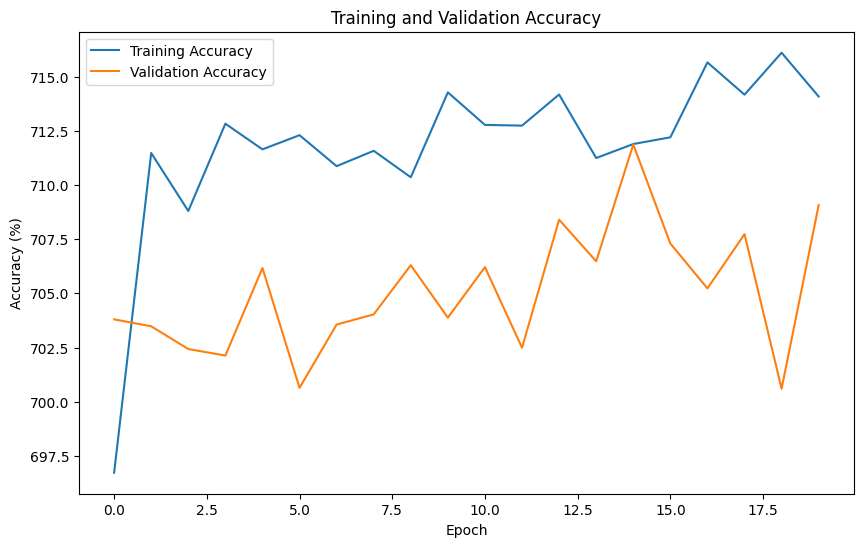

Batch size: 128, Optimizer: SGD


Epoch 1/20: 100%|██████████| 391/391 [00:34<00:00, 11.26batch/s, accuracy=1.28e+3, loss=2.3] 


[Epoch 1] train=1278.908000 val=1292.020000 loss=2.299787 time: 42.591249


Epoch 2/20: 100%|██████████| 391/391 [00:34<00:00, 11.42batch/s, accuracy=1.3e+3, loss=1.89] 


[Epoch 2] train=1303.074000 val=1300.330000 loss=1.885029 time: 42.036089


Epoch 3/20: 100%|██████████| 391/391 [00:40<00:00,  9.65batch/s, accuracy=1.31e+3, loss=1.69]


[Epoch 3] train=1305.396000 val=1307.750000 loss=1.685967 time: 48.154456


Epoch 4/20: 100%|██████████| 391/391 [00:40<00:00,  9.63batch/s, accuracy=1.3e+3, loss=1.56] 


[Epoch 4] train=1304.470000 val=1312.180000 loss=1.562821 time: 50.057319


Epoch 5/20: 100%|██████████| 391/391 [00:40<00:00,  9.57batch/s, accuracy=1.32e+3, loss=1.47]


[Epoch 5] train=1319.024000 val=1311.850000 loss=1.465345 time: 50.156503


Epoch 6/20: 100%|██████████| 391/391 [00:41<00:00,  9.46batch/s, accuracy=1317.73, loss=1.4] 


[Epoch 6] train=1317.730000 val=1315.880000 loss=1.396354 time: 50.643286


Epoch 7/20: 100%|██████████| 391/391 [00:37<00:00, 10.43batch/s, accuracy=1319.12, loss=1.34]


[Epoch 7] train=1319.120000 val=1319.390000 loss=1.338857 time: 45.235348


Epoch 8/20: 100%|██████████| 391/391 [00:40<00:00,  9.56batch/s, accuracy=1.32e+3, loss=1.28]


[Epoch 8] train=1324.468000 val=1323.700000 loss=1.277468 time: 49.828436


Epoch 9/20: 100%|██████████| 391/391 [00:38<00:00, 10.04batch/s, accuracy=1.33e+3, loss=1.23]


[Epoch 9] train=1325.346000 val=1321.810000 loss=1.230241 time: 47.352187


Epoch 10/20: 100%|██████████| 391/391 [00:34<00:00, 11.39batch/s, accuracy=1329.68, loss=1.19]


[Epoch 10] train=1329.680000 val=1325.420000 loss=1.190614 time: 42.973603


Epoch 11/20: 100%|██████████| 391/391 [00:36<00:00, 10.67batch/s, accuracy=1.32e+3, loss=1.17]


[Epoch 11] train=1324.036000 val=1327.610000 loss=1.166134 time: 44.636900


Epoch 12/20: 100%|██████████| 391/391 [00:38<00:00, 10.08batch/s, accuracy=1.33e+3, loss=1.13]


[Epoch 12] train=1332.528000 val=1325.710000 loss=1.125599 time: 48.020840


Epoch 13/20: 100%|██████████| 391/391 [00:42<00:00,  9.30batch/s, accuracy=1327.65, loss=1.1] 


[Epoch 13] train=1327.650000 val=1330.070000 loss=1.099817 time: 49.715995


Epoch 14/20: 100%|██████████| 391/391 [00:40<00:00,  9.74batch/s, accuracy=1328.72, loss=1.07]


[Epoch 14] train=1328.720000 val=1331.170000 loss=1.072260 time: 47.784459


Epoch 15/20: 100%|██████████| 391/391 [00:37<00:00, 10.52batch/s, accuracy=1.33e+3, loss=1.05]


[Epoch 15] train=1328.046000 val=1332.420000 loss=1.045868 time: 46.279631


Epoch 16/20: 100%|██████████| 391/391 [00:39<00:00,  9.93batch/s, accuracy=1.33e+3, loss=1.02]


[Epoch 16] train=1331.404000 val=1331.400000 loss=1.024372 time: 48.578248


Epoch 17/20: 100%|██████████| 391/391 [00:41<00:00,  9.34batch/s, accuracy=1.33e+3, loss=1]    


[Epoch 17] train=1328.372000 val=1331.800000 loss=1.004250 time: 50.092384


Epoch 18/20: 100%|██████████| 391/391 [00:37<00:00, 10.34batch/s, accuracy=1.34e+3, loss=0.978]


[Epoch 18] train=1340.606000 val=1333.780000 loss=0.978036 time: 47.446282


Epoch 19/20: 100%|██████████| 391/391 [00:40<00:00,  9.73batch/s, accuracy=1336.93, loss=0.953]


[Epoch 19] train=1336.930000 val=1335.480000 loss=0.952705 time: 47.782108


Epoch 20/20: 100%|██████████| 391/391 [00:37<00:00, 10.38batch/s, accuracy=1.34e+3, loss=0.94] 


[Epoch 20] train=1336.966000 val=1334.340000 loss=0.939969 time: 45.311924


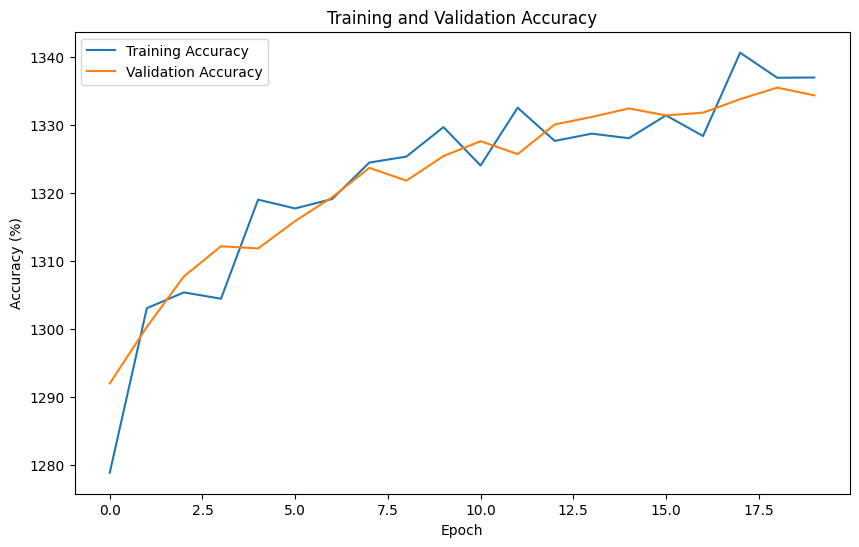

Batch size: 128, Optimizer: Adam


Epoch 1/20: 100%|██████████| 391/391 [00:38<00:00, 10.22batch/s, accuracy=1.3e+3, loss=1.9] 


[Epoch 1] train=1301.176000 val=1311.570000 loss=1.895032 time: 47.086115


Epoch 2/20: 100%|██████████| 391/391 [00:36<00:00, 10.74batch/s, accuracy=1.32e+3, loss=1.4] 


[Epoch 2] train=1318.934000 val=1317.970000 loss=1.403285 time: 45.595407


Epoch 3/20: 100%|██████████| 391/391 [00:37<00:00, 10.31batch/s, accuracy=1.33e+3, loss=1.2] 


[Epoch 3] train=1331.322000 val=1334.310000 loss=1.203190 time: 46.203359


Epoch 4/20: 100%|██████████| 391/391 [00:38<00:00, 10.20batch/s, accuracy=1.33e+3, loss=1.09]


[Epoch 4] train=1334.178000 val=1334.430000 loss=1.085530 time: 47.433240


Epoch 5/20: 100%|██████████| 391/391 [00:35<00:00, 11.17batch/s, accuracy=1.33e+3, loss=1.01]


[Epoch 5] train=1330.862000 val=1334.230000 loss=1.006602 time: 42.925224


Epoch 6/20: 100%|██████████| 391/391 [00:38<00:00, 10.15batch/s, accuracy=1.34e+3, loss=0.936]


[Epoch 6] train=1337.122000 val=1333.500000 loss=0.935834 time: 45.835833


Epoch 7/20: 100%|██████████| 391/391 [00:35<00:00, 11.01batch/s, accuracy=1.34e+3, loss=0.9]  


[Epoch 7] train=1337.646000 val=1339.440000 loss=0.899910 time: 44.351418


Epoch 8/20: 100%|██████████| 391/391 [00:34<00:00, 11.36batch/s, accuracy=1.34e+3, loss=0.852]


[Epoch 8] train=1339.652000 val=1342.060000 loss=0.852204 time: 42.325496


Epoch 9/20: 100%|██████████| 391/391 [00:36<00:00, 10.77batch/s, accuracy=1.34e+3, loss=0.815]


[Epoch 9] train=1340.094000 val=1340.740000 loss=0.814709 time: 44.174394


Epoch 10/20: 100%|██████████| 391/391 [00:35<00:00, 11.02batch/s, accuracy=1.34e+3, loss=0.776]


[Epoch 10] train=1343.248000 val=1341.090000 loss=0.776193 time: 43.709364


Epoch 11/20: 100%|██████████| 391/391 [00:35<00:00, 10.96batch/s, accuracy=1.34e+3, loss=0.756]


[Epoch 11] train=1340.146000 val=1343.220000 loss=0.755663 time: 43.444340


Epoch 12/20: 100%|██████████| 391/391 [00:36<00:00, 10.65batch/s, accuracy=1341.62, loss=0.726]


[Epoch 12] train=1341.620000 val=1342.440000 loss=0.725574 time: 45.416901


Epoch 13/20: 100%|██████████| 391/391 [00:36<00:00, 10.58batch/s, accuracy=1.35e+3, loss=0.695]


[Epoch 13] train=1347.768000 val=1346.150000 loss=0.695131 time: 44.039649


Epoch 14/20: 100%|██████████| 391/391 [00:36<00:00, 10.58batch/s, accuracy=1343.82, loss=0.673]


[Epoch 14] train=1343.820000 val=1345.580000 loss=0.673060 time: 44.054111


Epoch 15/20: 100%|██████████| 391/391 [00:36<00:00, 10.82batch/s, accuracy=1.34e+3, loss=0.662]


[Epoch 15] train=1343.842000 val=1340.270000 loss=0.662431 time: 43.342539


Epoch 16/20: 100%|██████████| 391/391 [00:37<00:00, 10.55batch/s, accuracy=1.35e+3, loss=0.633]


[Epoch 16] train=1345.746000 val=1345.610000 loss=0.633445 time: 45.874202


Epoch 17/20: 100%|██████████| 391/391 [00:41<00:00,  9.39batch/s, accuracy=1.35e+3, loss=0.622]


[Epoch 17] train=1345.768000 val=1346.230000 loss=0.622000 time: 49.426947


Epoch 18/20: 100%|██████████| 391/391 [00:41<00:00,  9.42batch/s, accuracy=1.35e+3, loss=0.597]


[Epoch 18] train=1346.516000 val=1349.060000 loss=0.597071 time: 50.333486


Epoch 19/20: 100%|██████████| 391/391 [00:38<00:00, 10.06batch/s, accuracy=1.35e+3, loss=0.587]


[Epoch 19] train=1349.724000 val=1344.240000 loss=0.586741 time: 46.654832


Epoch 20/20: 100%|██████████| 391/391 [00:41<00:00,  9.53batch/s, accuracy=1.35e+3, loss=0.579]


[Epoch 20] train=1348.332000 val=1344.950000 loss=0.578945 time: 49.820698


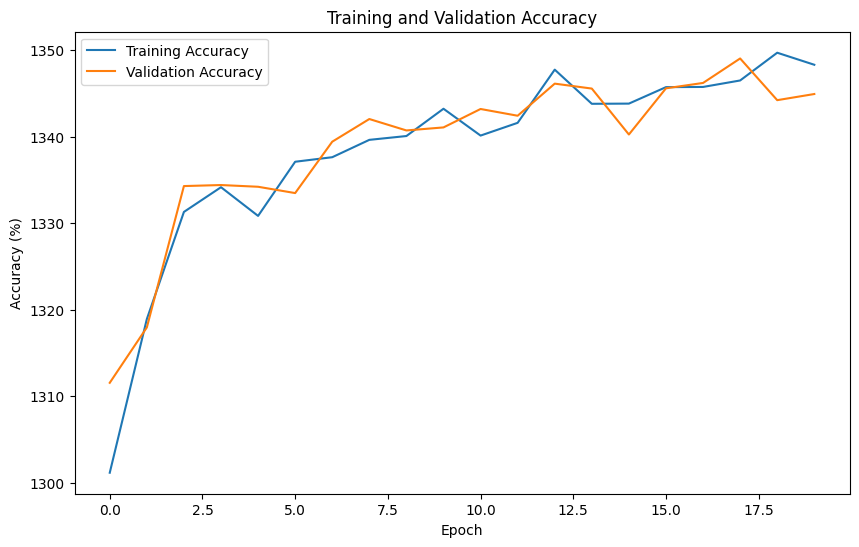

Batch size: 128, Optimizer: RMSprop


Epoch 1/20: 100%|██████████| 391/391 [00:39<00:00,  9.98batch/s, accuracy=1.29e+3, loss=2.2] 


[Epoch 1] train=1294.984000 val=1308.730000 loss=2.201086 time: 47.932265


Epoch 2/20: 100%|██████████| 391/391 [00:47<00:00,  8.24batch/s, accuracy=1.33e+3, loss=1.1] 


[Epoch 2] train=1334.592000 val=1342.310000 loss=1.102766 time: 57.156738


Epoch 3/20: 100%|██████████| 391/391 [00:41<00:00,  9.52batch/s, accuracy=1.35e+3, loss=0.729]


[Epoch 3] train=1347.044000 val=1341.810000 loss=0.728794 time: 50.059074


Epoch 4/20: 100%|██████████| 391/391 [00:41<00:00,  9.52batch/s, accuracy=1.35e+3, loss=0.671]


[Epoch 4] train=1348.012000 val=1345.900000 loss=0.671110 time: 49.595786


Epoch 5/20: 100%|██████████| 391/391 [00:38<00:00, 10.17batch/s, accuracy=1.35e+3, loss=0.642]


[Epoch 5] train=1347.878000 val=1343.940000 loss=0.641539 time: 46.142248


Epoch 6/20: 100%|██████████| 391/391 [00:47<00:00,  8.19batch/s, accuracy=1.35e+3, loss=0.618]


[Epoch 6] train=1348.784000 val=1340.710000 loss=0.617962 time: 56.737704


Epoch 7/20:   8%|▊         | 33/391 [00:05<00:53,  6.74batch/s, accuracy=1.35e+3, loss=0.573]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 8/20: 100%|██████████| 98/98 [00:37<00:00,  2.61batch/s, accuracy=5.15e+3, loss=1.42]


[Epoch 8] train=5151.788000 val=5101.810000 loss=1.416192 time: 46.757846


Epoch 9/20: 100%|██████████| 98/98 [00:38<00:00,  2.56batch/s, accuracy=5.14e+3, loss=1.41]


In [ ]:
import time
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn import init
from tqdm import tqdm

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR10 dataset with the transformations
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_sizes = [64, 128, 256, 512]
for batch_size in batch_sizes:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Initialize the model
    model = SqueezeNet_Residual(num_classes=10).to(device)

    # Try different weight initialization methods
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal_(m.weight, 0, 0.01)
            init.constant_(m.bias, 0)

    # Try different optimizers
    optimizers = [
        optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
        optim.Adam(model.parameters(), lr=0.001),
        optim.RMSprop(model.parameters(), lr=0.001)
    ]
    for optimizer in optimizers:
        criterion = nn.CrossEntropyLoss(ignore_index=-1)
        optimizer = optimizer

        # Training loop
        train_acc_history = []
        val_acc_history = []
        num_epochs = 20

        print(f"Batch size: {batch_size}, Optimizer: {type(optimizer).__name__}")

        for epoch in range(num_epochs):
            running_loss = 0.0
            tic = time.time()

            # Training loop
            correct = 0
            total = 0
            progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
            for i, data in enumerate(progress_bar):
                inputs, labels = data[0].to(device), data[1].to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                labels = labels.unsqueeze(1).unsqueeze(2)  # Reshape labels to 3D tensor
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels.squeeze()).sum().item()
                progress_bar.set_postfix(loss=running_loss / (i+1), accuracy=100 * correct / total)

            train_acc = 100 * correct / total
            train_acc_history.append(train_acc)

            # Validation loop
            correct = 0
            total = 0
            for i, data in enumerate(testloader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            val_acc = 100 * correct / total
            val_acc_history.append(val_acc)

            print(f'[Epoch {epoch + 1}] train={train_acc:.6f} val={val_acc:.6f} loss={running_loss / len(trainloader):.6f} time: {time.time() - tic:.6f}')

        # Plot the training and validation accuracy
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        plt.plot(train_acc_history, label='Training Accuracy')
        plt.plot(val_acc_history, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.show()

In [ ]:
import time
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn import init
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR10 dataset with the transformations
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_sizes = [64, 128, 256, 512]
for batch_size in batch_sizes:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Initialize the model
    model = SqueezeNet_Residual(num_classes=10).to(device)

    # Try different weight initialization methods
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal_(m.weight, 0, 0.01)
            init.constant_(m.bias, 0)

    # Try different optimizers
    optimizers = [
        optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
        optim.Adam(model.parameters(), lr=0.001),
        optim.RMSprop(model.parameters(), lr=0.001)
    ]
    for optimizer in optimizers:
        criterion = nn.CrossEntropyLoss(ignore_index=-1)
        optimizer = optimizer

        # Initialize the learning rate scheduler
        scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True)

        # Training loop
        train_acc_history = []
        val_acc_history = []
        num_epochs = 20

        print(f"Batch size: {batch_size}, Optimizer: {type(optimizer).__name__}")

        for epoch in range(num_epochs):
            running_loss = 0.0
            tic = time.time()

            # Training loop
            correct = 0
            total = 0
            progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
            for i, data in enumerate(progress_bar):
                inputs, labels = data[0].to(device), data[1].to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                labels = labels.unsqueeze(1).unsqueeze(2)  # Reshape labels to 3D tensor
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels.squeeze()).sum().item()
                progress_bar.set_postfix(loss=running_loss / (i+1), accuracy=100 * correct / total)

            train_acc = 100 * correct / total
            train_acc_history.append(train_acc)

            # Validation loop
            correct = 0
            total = 0
            for i, data in enumerate(testloader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            val_acc = 100 * correct / total
            val_acc_history.append(val_acc)

            # Update the learning rate scheduler
            scheduler.step(running_loss / len(trainloader))

            print(f'[Epoch {epoch + 1}] train={train_acc:.6f} val={val_acc:.6f} loss={running_loss / len(trainloader):.6f} time: {time.time() - tic:.6f}')

        # Plot the training and validation accuracy
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        plt.plot(train_acc_history, label='Training Accuracy')
        plt.plot(val_acc_history, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.show()